# Main

In [14]:
from skimage.transform import iradon
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# Expects all arrays to be of the same length, this comes automatically from the PET lab collection
def readData(directory):
    angle_pattern = re.compile(r"(-?\d+_\d+)\s*Deg")
    angle_to_counts = {}
    distances_ref = []
    for fname in os.listdir(directory):
        if not fname.endswith(".dat"):
            continue
        # print(fname)

        match = angle_pattern.search(fname)
        if not match:
            raise ValueError(f"Angle not found in filename: {fname}")

        angle = float(match.group(1).replace("_", "."))

        data = pd.read_csv(
            os.path.join(directory, fname),
            sep=r"\s+",
            skiprows=1,
            names=["Distance", "Counts"]
        )
        # print(distances_ref)
        # if distances_ref is None:
        if (np.size(distances_ref) == 0):
            distances_ref = data["Distance"].to_numpy()
        elif (not (distances_ref == data["Distance"].to_numpy()).all()):
            raise ValueError("Distance grid mismatch in file: " + fname)
        # print(distances_ref)

        angle_to_counts[angle] = data["Counts"].to_numpy()

    angles = np.array(sorted(angle_to_counts.keys()))
    # print(angles)
    # Build 2D array: rows = distance, cols = angle
    counts_2d = np.column_stack([angle_to_counts[a] for a in angles])
    
    midpoint = (distances_ref[-1] - distances_ref[0])/2
    distances_ref = distances_ref - midpoint
    # print(distances_ref)
    return counts_2d, distances_ref, angles

def display_raw_sinogram(count, distance, angle, savename):
    plt.figure()
    plt.imshow(
        count,
        origin="lower",
        aspect="auto",
        extent=[
            angle[0], angle[-1],
            distance[0], distance[-1]],
        cmap="gray"
    )
    plt.title("Raw Sinogram")
    plt.xlabel("Angle (deg)")
    plt.ylabel("Distance (mm)")
    plt.colorbar(label="Counts")
    plt.savefig(savename)
    plt.show()
    return

def display_reconstructed_image(recon, distance, savename):
    plt.figure()
    plt.imshow(recon, extent=[
        distance[0], distance[-1],
        distance[0], distance[-1]],
               cmap="gray", origin="lower")
    plt.colorbar(label="Reconstructed intensity")
    plt.title("Backprojection reconstruction")
    plt.ylabel("Distance (mm)")
    plt.xlabel("Distance (mm)")
    plt.savefig(savename)
    plt.show()
    return


In [63]:

directory = "./data/Preliminary Scan - 2026-01-09"
countArr, distance, angles = readData(directory)


In [64]:
print(distance)

[-25.  -24.5 -24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5
 -19.  -18.5 -18.  -17.5 -17.  -16.5 -16.  -15.5 -15.  -14.5 -14.  -13.5
 -13.  -12.5 -12.  -11.5 -11.  -10.5 -10.   -9.5  -9.   -8.5  -8.   -7.5
  -7.   -6.5  -6.   -5.5  -5.   -4.5  -4.   -3.5  -3.   -2.5  -2.   -1.5
  -1.   -0.5   0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5
   5.    5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5
  11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5
  17.   17.5  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5
  23.   23.5  24.   24.5  25. ]


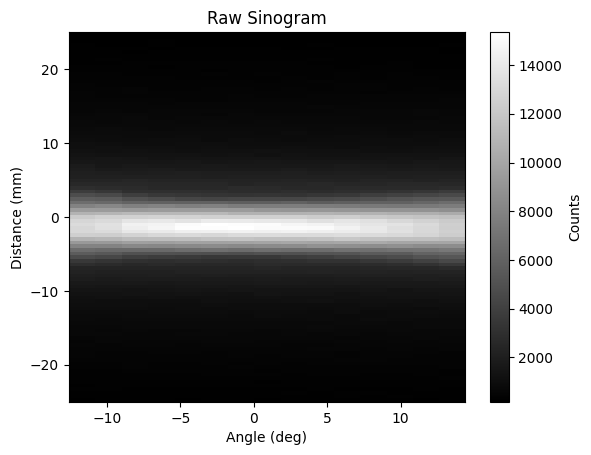

In [65]:
angles = angles + 14.4
display_raw_sinogram(countArr, distance, angles, "prelim scan sinogram")

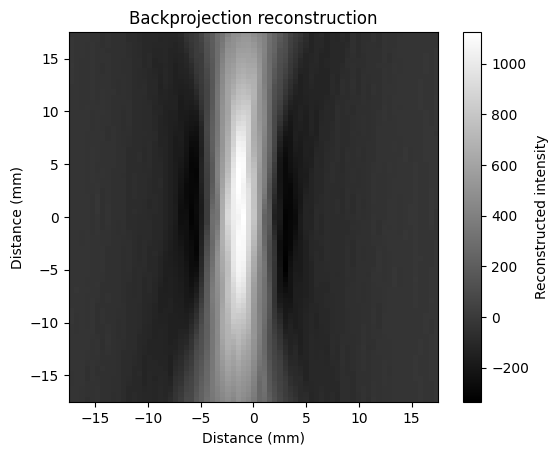

In [66]:

recon = iradon( countArr, theta=angles, filter_name="ramp", circle=False)
dimx, dimy = recon.shape
step_size = distance[1] - distance[0] # I know that step size is constant
half_width = (dimx - 1) * step_size / 2

recon_distance = np.linspace(-half_width, half_width, dimx)

display_reconstructed_image(recon, recon_distance, "prelim scan reconstruction")
# plt.figure()
# plt.imshow(recon, cmap="gray_r", origin="lower")
# plt.colorbar(label="Reconstructed intensity")
# plt.title("Backprojection reconstruction")
# plt.ylabel("Distance (mm)")
# plt.xlabel("Distance (mm)")
# plt.show()